# Advanced Lane Lines Detection Pipeline

## Importing Packages

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import ntpath

%matplotlib inline

# Make the plotImages function available
%run PlottingHelperFunctions.ipynb

## Index

1. [Correcting Image Distortion](#Correcting-Image-Distortion)

2. [Calibrating the Camera](#Calibrating-the-Camera)



## Correcting Image Distortion

In [2]:
def distortionCorrection(img, mtx, dist):
    # use the camera calibration matrix and distortion coefficients to 
    # undistort an image
    correctedImage = cv2.undistort(img, mtx, dist, None, mtx)
    return correctedImage

## Calibrating the Camera

In [3]:
# globals used internally by the calibrateCamera function
gCamCalMatrix = None
gCamCalDistortionCoeff = None 

def calibrateCamera():
    # return if the global camCalMatrix already exists
    global gCamCalMatrix
    global gCamCalDistortionCoeff
    
    if(gCamCalMatrix is not None):
        return gCamCalMatrix, gCamCalDistortionCoeff
    
    # keep track of one of the grayscaled calibration images
    grayImage = None
    
    # keep track of images and their names
    images = []
    imageNames = []
    
    # create object points and image points arrays for all images
    objectPoints = [] # 3D Points to hold position in real world space
    imagePoints  = [] # 2D Points to hold position in the image plane

    # prepare object points
    objectPoint = np.zeros((9*6, 3), np.float32)
    objectPoint[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    # use calibration images
    for fileName in glob.glob("camera_cal/*.jpg"):
        # read in image
        image = mpimg.imread(fileName)
        # convert to gray scale
        grayImage = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
        # find chessboard corners for a 9x6 board
        ret, corners = cv2.findChessboardCorners(grayImage, (9,6), None)
        
        # append object and image points if corners found
        if ret:
            objectPoints.append(objectPoint)
            imagePoints.append(corners)
    
    if grayImage is not None:
        ret, gCamCalMatrix, gCamCalDistortionCoeff, rVecs, tVecs = cv2.calibrateCamera(objectPoints, 
                                                                                       imagePoints, 
                                                                                       grayImage.shape[::-1], 
                                                                                       None, None)
        
    return gCamCalMatrix, gCamCalDistortionCoeff

## Visualizing Camera Calibration

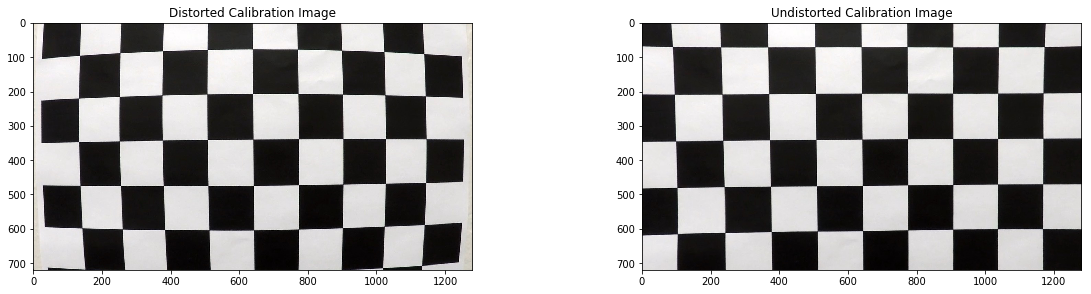

In [4]:
# calibrate camera
M, dist = calibrateCamera()
# undistort a calibration image
distortedCalibrationImage = mpimg.imread("camera_cal/calibration1.jpg")
undistortedCalibrationImage = distortionCorrection(distortedCalibrationImage, M, dist)
# visualize the change
plotImages([distortedCalibrationImage, 
           undistortedCalibrationImage], 
           ["Distorted Calibration Image", "Undistorted Calibration Image"], 
           2)
# save the output for the writeup
mpimg.imsave("output_images/distortedCalibrationImage.jpg",   distortedCalibrationImage)
mpimg.imsave("output_images/undistortedCalibrationImage.jpg", undistortedCalibrationImage)

## Applying and Reversing Bird's Eye View Perspective Transform

In [5]:
# global for tracking perspective transform matrix and its inverse (so we don't have to recalculate them every time)
gPerspectiveTransform = {}

def getBirdsEyeSrcDstPoints(img):
    # get image shape properties
    height, width, channels = img.shape
    
    # TODO: Error checking / do not choose values statically
    
    # inspired by region provided in the writeup_template
    src = np.float32(
        [[width-695,    460],
         [203,       height],
         [width-153, height],
         [695,         460]])
    
    dst = np.float32(
        [[width - 960,      0],
         [width - 960, height],
         [960,         height],
         [960,             0]])

    return src, dst

def applyPerspectiveTransform(img, src, dst, M=None):
    global gPerspectiveTransform
    height, width, channels = img.shape
    
    if M is None:
        M = cv2.getPerspectiveTransform(src, dst)
    
    # apply warp perspective with the matrix responsible for a linear transformation from src to dst (or dst to src if reversed)
    return cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR), M

def drawBirdsEyeViewSourcePoints(img):
    # get the source and destination points necessary
    # for warping to a birds eye view
    src, dst = getBirdsEyeSrcDstPoints(img)
    
    # copy the image
    imgCopy = np.copy(img)
    
    # prepare source points for visualization
    pts = np.array(src, np.int32)
    pts = pts.reshape((-1,1,2))
    
    # visualize the source points via cv2.polylines
    cv2.polylines(imgCopy,[pts],True,(0,0,255), 5)
    
    return imgCopy

def birdsEyeView(img, reverse=False):
    # get the source and destination points necessary
    # for warping to a birds eye view
    src, dst = getBirdsEyeSrcDstPoints(img)
    
    # decide what kind of transformation this is
    prop = "M"
    
    if reverse:
        prop = "invM"
        # flip src and dst
        tmp = src
        src = dst
        dst = tmp
        
    # either used hashed M/invM or calculate new one
    if prop in gPerspectiveTransform:
        result, gPerspectiveTransform[prop] = applyPerspectiveTransform(img, src, dst, M=gPerspectiveTransform[prop])
    else:
        result, gPerspectiveTransform[prop] = applyPerspectiveTransform(img, src, dst)
    
    return result

## Visualizing Birds Eye View Transform

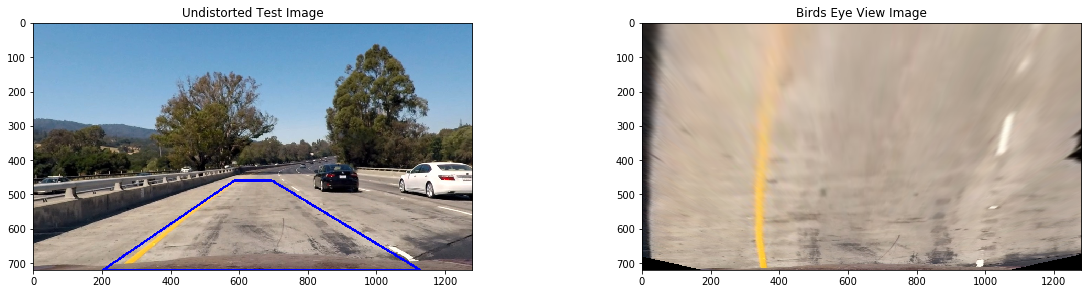

In [6]:
# apply birds eye view to an undistorted test image
distortedTestImage = mpimg.imread("test_images/test1.jpg")
undistortedTestImage = distortionCorrection(distortedTestImage, gCamCalMatrix, gCamCalDistortionCoeff)
undistortedTestImageWithSrcPoints = drawBirdsEyeViewSourcePoints(undistortedTestImage)
birdsEyeViewImage = birdsEyeView(undistortedTestImage)
# visualize the change
plotImages([undistortedTestImageWithSrcPoints, 
           birdsEyeViewImage], 
           ["Undistorted Test Image", "Birds Eye View Image"], 
           2)
# save the output for the writeup
mpimg.imsave("output_images/distortedTestImage.jpg",        distortedTestImage)
mpimg.imsave("output_images/undistortedTestImage.jpg",    undistortedTestImage)
mpimg.imsave("output_images/birdsEyeViewBeforeImage.jpg", undistortedTestImageWithSrcPoints)
mpimg.imsave("output_images/birdsEyeViewAfterImage.jpg",     birdsEyeViewImage)

## Accentuating Lane Lines

Testing Color Transforms...


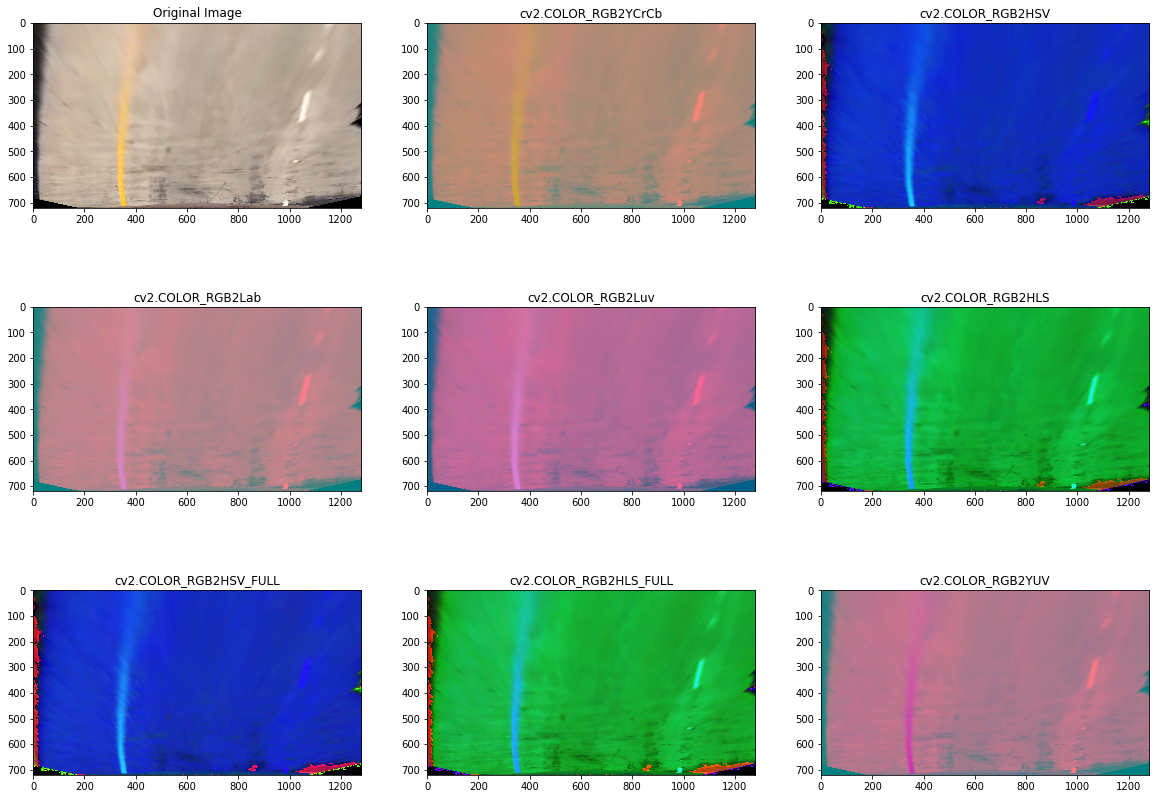

Testing Sobel X Gradient Thresholds...
Testing Gradient Thresh:  (35, 170)
Testing Gradient Thresh:  (20, 170)
Testing Gradient Thresh:  (15, 170)
Testing Gradient Thresh:  (10, 170)
Testing Gradient Thresh:  (5, 170)


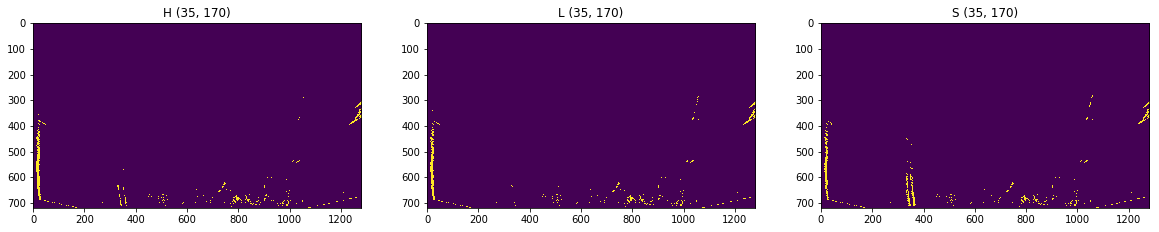

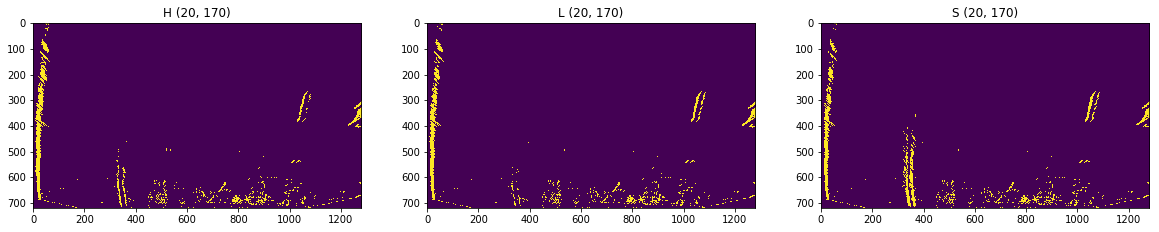

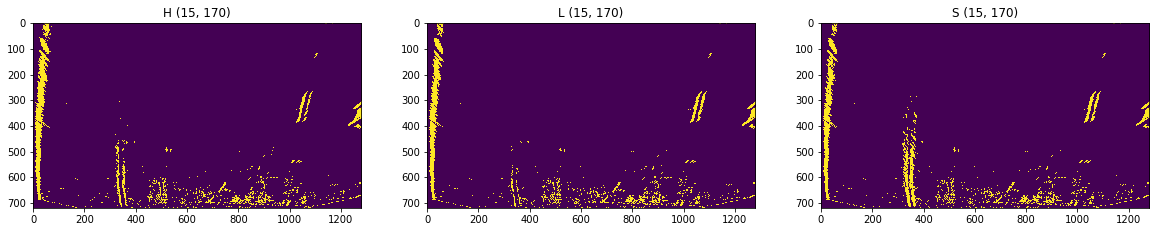

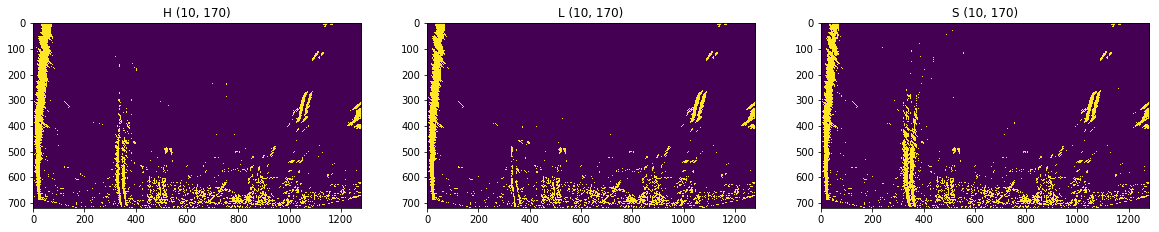

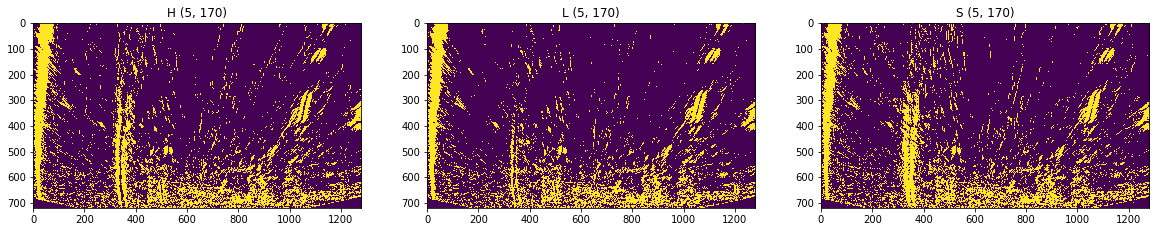

Testing HLS White and Yellow Mask...


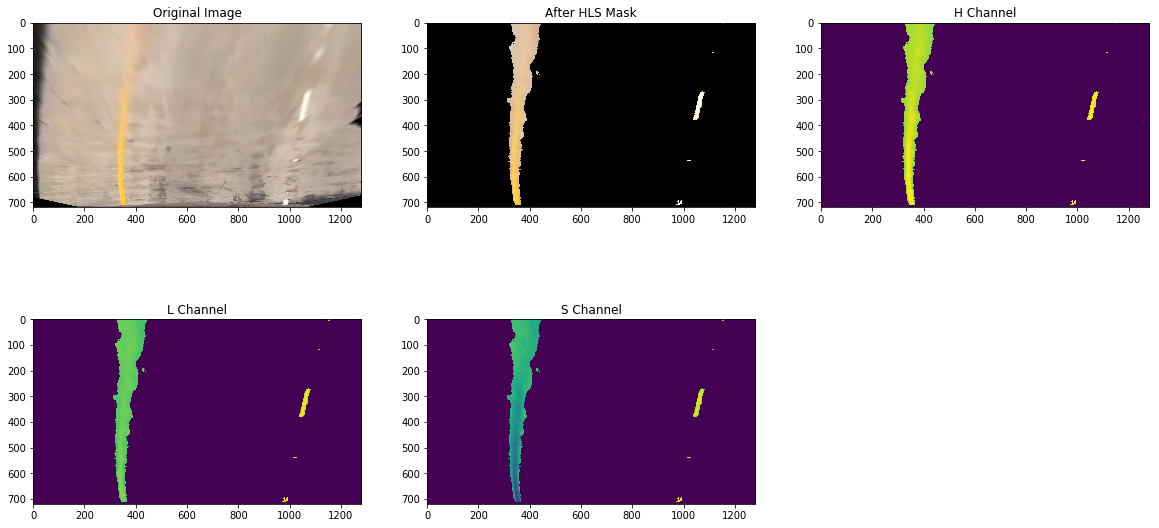

Testing Sobel and HLS Color Filtering Combination...


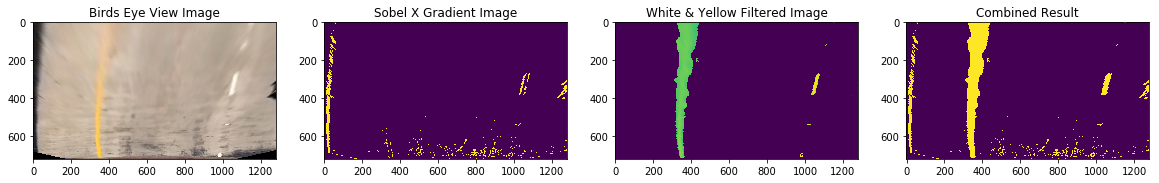

In [7]:
# Make the accentuateLaneLines function available
%run AccentuateLaneLines.ipynb

## Lane Lines Helper Class

In [8]:
import math

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # how long to keep track of previous detections (n)
        self.history = 5
        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # x values of the last n fits of the line (most recent in front)
        self.recent_xfitted = []
        # contains the last n fits of the line (most recent in front)
        self.fitHistory = []
        # polynomial coefficients for the most recent fit
        self.current_fit = None 
        # radius of curvature of the line in meters
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
    
    def updateRadiusOfCurvature(self, imgShape, fit):
        '''
            PARAMATERS: 
                self     -> a Line Object
                imgShape -> the shape of an image
                fit      -> polynomial representing the lane line
        ''' 

        # get y values in world space
        y = self.ym_per_pix*np.max(np.linspace(0, imgShape[0] - 1, imgShape[0]))
        A = fit[0]
        B = fit[1]

        # plug in values to radius of curvature equation
        firstDerivative = 2*A*y + B
        secondDerivative = 2*A
        self.radius_of_curvature = (1 + (2*A*y + B)**2)**(3/2) / (np.abs(2*A))
    
    def fitPoly(self, imgShape, lineX, lineY):
        '''
            PARAMATERS: 
                self     -> a Line Object
                imgShape -> the shape of an image
                lineX    -> X coordinates of a lane line found on an image
                lineY    -> Y coordinates of a lane line found on an image
        ''' 
        
        # Fit a second order polynomial to this line with np.polyfit()
        newFit  = np.polyfit(lineY, lineX, 2)
                    
        # keep track of the new fit (most recent fit in front)
        self.fitHistory.insert(0, newFit)
        
        # make sure we are only keeping track within our allowed
        # history limit
        if len(self.fitHistory) > self.history:
            # remove last from list
            self.fitHistory.pop(len(self.fitHistory) - 1)
        
        # assign current fit to the average of this new fit and previous fits
        self.current_fit = np.mean(self.fitHistory, axis=0)
        
        # Generate y values for plotting
        plotY = np.linspace(0, imgShape[0] - 1, imgShape[0])

        fit_m = np.polyfit(self.ym_per_pix*lineY, self.xm_per_pix*lineX, 2)
        self.updateRadiusOfCurvature(imgShape, fit_m)
        
        fit = self.current_fit
        # Calculate the the points resulting from the polynomial using generated y points
        try:
            self.detected = True
            fitX = fit[0]*plotY**2 + fit[1]*plotY + fit[2]
        except TypeError:
            # Avoids an error if fit is still none or incorrect
            self.detected = False
            print('The function failed to fit a line!')
            fitX = 1*plotY**2 + 1*plotY
        
        return fitX, plotY

# Polynomial fit values from the previous frame
leftLine  = Line() 
rightLine = Line()

## Radius of Curvature and Car Distance from Lane Center

In [9]:
def carDistanceFromCenter(width, height):
    global leftLine
    global rightLine

    # lamda that takes a polyfit and a y value and returns the resulting x
    fitF = lambda ft, y: ft[0]*y**2 + ft[1]*y + ft[2]
    
    # median of the left and right fits is where the lane center is (midpoint between our two detected lines)
    # Note: using the bottom most y value in our image to generate a usable x value
    laneCenterPosition = (fitF(leftLine.current_fit, height) + fitF(rightLine.current_fit, height)) / 2

    # Car center is positioned in the middle of the image (Assuming that the camera is in the center of the vehicle)
    carPosition = width / 2

    # distance from lane center is the difference between the car position and the lane center position
    # (convert to world space)
    carDistanceFromCenter = (carPosition - laneCenterPosition) * leftLine.xm_per_pix

    return carDistanceFromCenter

In [10]:
def laneLinesXBases(img):
    # NOTE: expects a binary image
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint]) 
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base

##  Finding Lane Pixels from a Window Search

In [ ]:
def find_lane_pixels(binary_warped, debug=False, nwindows=10, margin=100, minpix=50):
    '''
        PARAMETERS:
            binary_warped -> binary image that will be processed to detect lane lines
            nwindows      -> the number of sliding windows
            margin        ->  the width of the windows +/- margin
            minpix        ->  the minimum number of pixels needed to be found to recenter window

            debug         -> enables drawing search window visualizations onto the output image
    '''
    
    # Find the starting points for the left and right lines
    # (they will be updated later for each window in nwindows)
    leftx_current, rightx_current = laneLinesXBases(binary_warped)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image if
        # debug is enabled
        if debug:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

In [11]:
def windowSearch(binary_warped, debug=False):
    global leftLine
    global rightLine
        
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, debug)

    height, width, channels = out_img.shape
    
    # Fit a second order polynomial to each line
    left_fitx, ploty  = leftLine.fitPoly(out_img.shape,   leftx,  lefty)
    right_fitx, ploty = rightLine.fitPoly(out_img.shape, rightx, righty) 

    ## Visualization ##
    # Colors in the left and right lane regions
    # if debug is enabled
    if debug:
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

    # Draw in polynomials of left and right lines
    leftLinePoints  = np.array([[xPt, yPt] for xPt, yPt in zip(left_fitx,  ploty)], np.int32)
    out_img = cv2.polylines(out_img, [leftLinePoints], True, (255, 0, 0), 3)

    rightLinePoints = np.array([[xPt, yPt] for xPt, yPt in zip(right_fitx, ploty)], np.int32)
    out_img = cv2.polylines(out_img, [rightLinePoints], True, (0, 0, 255), 3)
    
    # fill lane with udacity color if not in debug
    if not debug:
        points = np.concatenate((leftLinePoints, rightLinePoints[::-1]))
        cv2.fillPoly(out_img, [np.int32(points)], color=[3,179,228])

    return out_img

##  Finding Lane Pixels from Previous Lane Lines

In [12]:
def searchFromPrevious(img, debug=False):
    global leftLine
    global rightLine
    left_fit  = leftLine.current_fit
    right_fit = rightLine.current_fit
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    # within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx,  ploty = leftLine.fitPoly(img.shape, leftx, lefty)
    right_fitx, ploty = rightLine.fitPoly(img.shape, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    if debug:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    result = np.zeros_like(out_img)
    
    # Draw the lane onto the warped blank image
    if debug:
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    rightLinePoints = np.array([[xPt, yPt] for xPt, yPt in zip(right_fitx, ploty)], np.int32)
    result = cv2.polylines(result, [rightLinePoints], True, (0, 0, 255), 3)
    
    leftLinePoints = np.array([[xPt, yPt] for xPt, yPt in zip(left_fitx, ploty)], np.int32)
    result = cv2.polylines(result, [leftLinePoints], True, (0, 0, 255), 3)

    # fill lane with udacity color if not in debug
    if not debug:
        points = np.concatenate((leftLinePoints, rightLinePoints[::-1]))
        cv2.fillPoly(result, [np.int32(points)], color=[3,179,228])

    return result

## Drawing Lane Line Properties

In [13]:
def drawLaneProperties(img, leftRad, rightRad, distFromCenter):
    height, width = img.shape[1], img.shape[0]

    fontSize = 1.35
    fontColor = (50, 230, 255)
    
    cv2.putText(img, "Radius of Curvature:", (50, 70), cv2.FONT_HERSHEY_DUPLEX, fontSize, fontColor, 2, cv2.LINE_AA)
    cv2.putText(img, "Left : " + "{:05.2f} m".format(leftRad), (50, 110), cv2.FONT_HERSHEY_DUPLEX, fontSize, fontColor, 2, cv2.LINE_AA)
    cv2.putText(img, "Right: " + "{:05.2f} m".format(rightRad), (50, 150), cv2.FONT_HERSHEY_DUPLEX, fontSize, fontColor, 2, cv2.LINE_AA)
    
    directionalText = "Right"
    
    # since the center is calculated from carPos - laneCenter,
    # a negative value means that the car is to the left of center
    if distFromCenter < 0:
        directionalText = "Left"
    
    text = "{:05.2f}".format(abs(distFromCenter)) + " m to the " + directionalText + " of Lane Center"
    
    cv2.putText(img, text, (50, 190), cv2.FONT_HERSHEY_DUPLEX, fontSize, fontColor, 2, cv2.LINE_AA)
    
    return img

In [14]:
def drawLaneLinesProperties(img):
    global leftLine
    global rightLine
    
    # get the current car distance from lane center
    distFromCenter = carDistanceFromCenter(img.shape[1], img.shape[0])
    
    # convert the radii of curvature to world space
    realLeftLineROC  = leftLine.radius_of_curvature  * leftLine.xm_per_pix
    realRightLineROC = rightLine.radius_of_curvature * rightLine.xm_per_pix
    
    drawLaneProperties(img, realLeftLineROC, realRightLineROC, distFromCenter)

## Identifying Lane Lines by Combining Window Search and Searching from Previous

In [15]:
def identifyLaneLines(img, debug=False):
    global leftLine
    global rightLine
    
    # update lines with new image
    if leftLine.detected and rightLine.detected:
        binaryPerspectiveImage = searchFromPrevious(img, debug)
    else:
        binaryPerspectiveImage = windowSearch(img, debug)
        
    return binaryPerspectiveImage

## Testing Identifying Lane Lines from B.E.V. Image

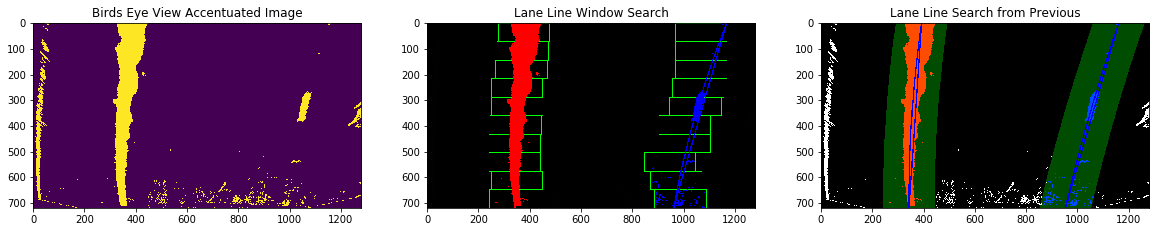

In [16]:
# clear line globals back to default for testing
rightLine = Line()
leftLine  = Line()

birdsEyeViewAccentuatedImage = accentuateLaneLines(mpimg.imread("output_images/birdsEyeViewAfterImage.jpg"))

laneLineImage1 = identifyLaneLines(birdsEyeViewAccentuatedImage, True)
laneLineImage2 = identifyLaneLines(birdsEyeViewAccentuatedImage, True)

plotImages([birdsEyeViewAccentuatedImage, laneLineImage1, laneLineImage2], 
           ["Birds Eye View Accentuated Image", "Lane Line Window Search", "Lane Line Search from Previous"], 3)

# save the output for the writeup
mpimg.imsave("output_images/birdsEyeViewLaneLineImageWindowSearch.jpg",  laneLineImage1)
mpimg.imsave("output_images/birdsEyeViewLaneLineImagePreviousSearch.jpg",  laneLineImage2)

## Adding Detected Lines Overlay to Original Image

In [17]:
def overlayDetectedLines(img, binaryDetectedLines):
    return cv2.addWeighted(img, 1, binaryDetectedLines, 1, 0)

In [18]:
def addImagesToImage(images, targetImage):
    xOffset=targetImage.shape[1]
    yOffset=0
    
    for i, img in enumerate(images):
        image = np.copy(img)

        # target image expected to be 3 channels
        # input img can be 3 channels or 1 channel, 
        # however it must be shaped to 3 channel
        if len(image.shape) < 3:
            image = np.stack((image,)*3, -1) * 255

        # resize the image and place on the target image
        dsize = (image.shape[1]//4, image.shape[0]//4)
        shrunkIm = cv2.resize(image, dsize=dsize)
        # draw it on the top right corner of the resulting image
        xOffset = xOffset - shrunkIm.shape[1]
        yOffset = 0
        
        targetImage[yOffset:yOffset+shrunkIm.shape[0], 
                    xOffset:xOffset+shrunkIm.shape[1]] = shrunkIm   

## Running the Lane Line Detection Pipeline

In [19]:
def pipeline(img, debug=False):
    # We must calibarate our camera with the provided chessboard images
    # (initializes on first call, uses globals on successive calls)
    camCalMatrix, camCalDistortionCoeff = calibrateCamera()
    
    # Apply distortion correction to the image with the computed
    # camera calibration matrix and distortion coefficients
    distortionCorrectedImage = distortionCorrection(img, camCalMatrix, camCalDistortionCoeff)
    
    # Apply a perspective transform (birds-eye view) to the distortion corrected image
    birdsEyeViewImage = birdsEyeView(distortionCorrectedImage)
    
    # Accentuate possible lane lines via color transform, gradients, and color highlighting (white and yellow)
    binaryBirdsEyeViewImage = accentuateLaneLines(birdsEyeViewImage)
        
    # Identify left and right lane lines on the perspective transformed binary image
    binaryLinesBirdsEyeViewImage = identifyLaneLines(binaryBirdsEyeViewImage, debug)
    
    # Transform the birds eye view image back to the original perspective
    binaryLinesImage = birdsEyeView(binaryLinesBirdsEyeViewImage, reverse=True)
            
    # Overlay the original image with the detected lane lines binary image
    detectedLinesOverlayImage = overlayDetectedLines(img, binaryLinesImage)
    
    if debug:
        addImagesToImage([binaryLinesBirdsEyeViewImage, binaryBirdsEyeViewImage, birdsEyeViewImage], detectedLinesOverlayImage)
    
    # write the average radius of curvature and the 
    # current distance from center onto the image 
    # (Note: uses global leftLine and rightLine)
    drawLaneLinesProperties(detectedLinesOverlayImage)
    
    if debug:
        plotImages([img, 
                    distortionCorrectedImage, 
                    birdsEyeViewImage, 
                    binaryBirdsEyeViewImage, 
                    binaryLinesBirdsEyeViewImage,
                    binaryLinesImage,
                    detectedLinesOverlayImage],
                  ["img", 
                    "distortionCorrectedImage", 
                    "birdsEyeViewImage", 
                    "binaryBirdsEyeViewImage", 
                    "binaryLinesBirdsEyeViewImage",
                    "binaryLinesImage",
                    "detectedLinesOverlayImage"],  
                  columns=3, figsize=(30,25))
    
    return detectedLinesOverlayImage

## Testing the Lane Line Detection Pipeline on Project Video Images

Running Pipeline On:  test_images\straight_lines1.jpg


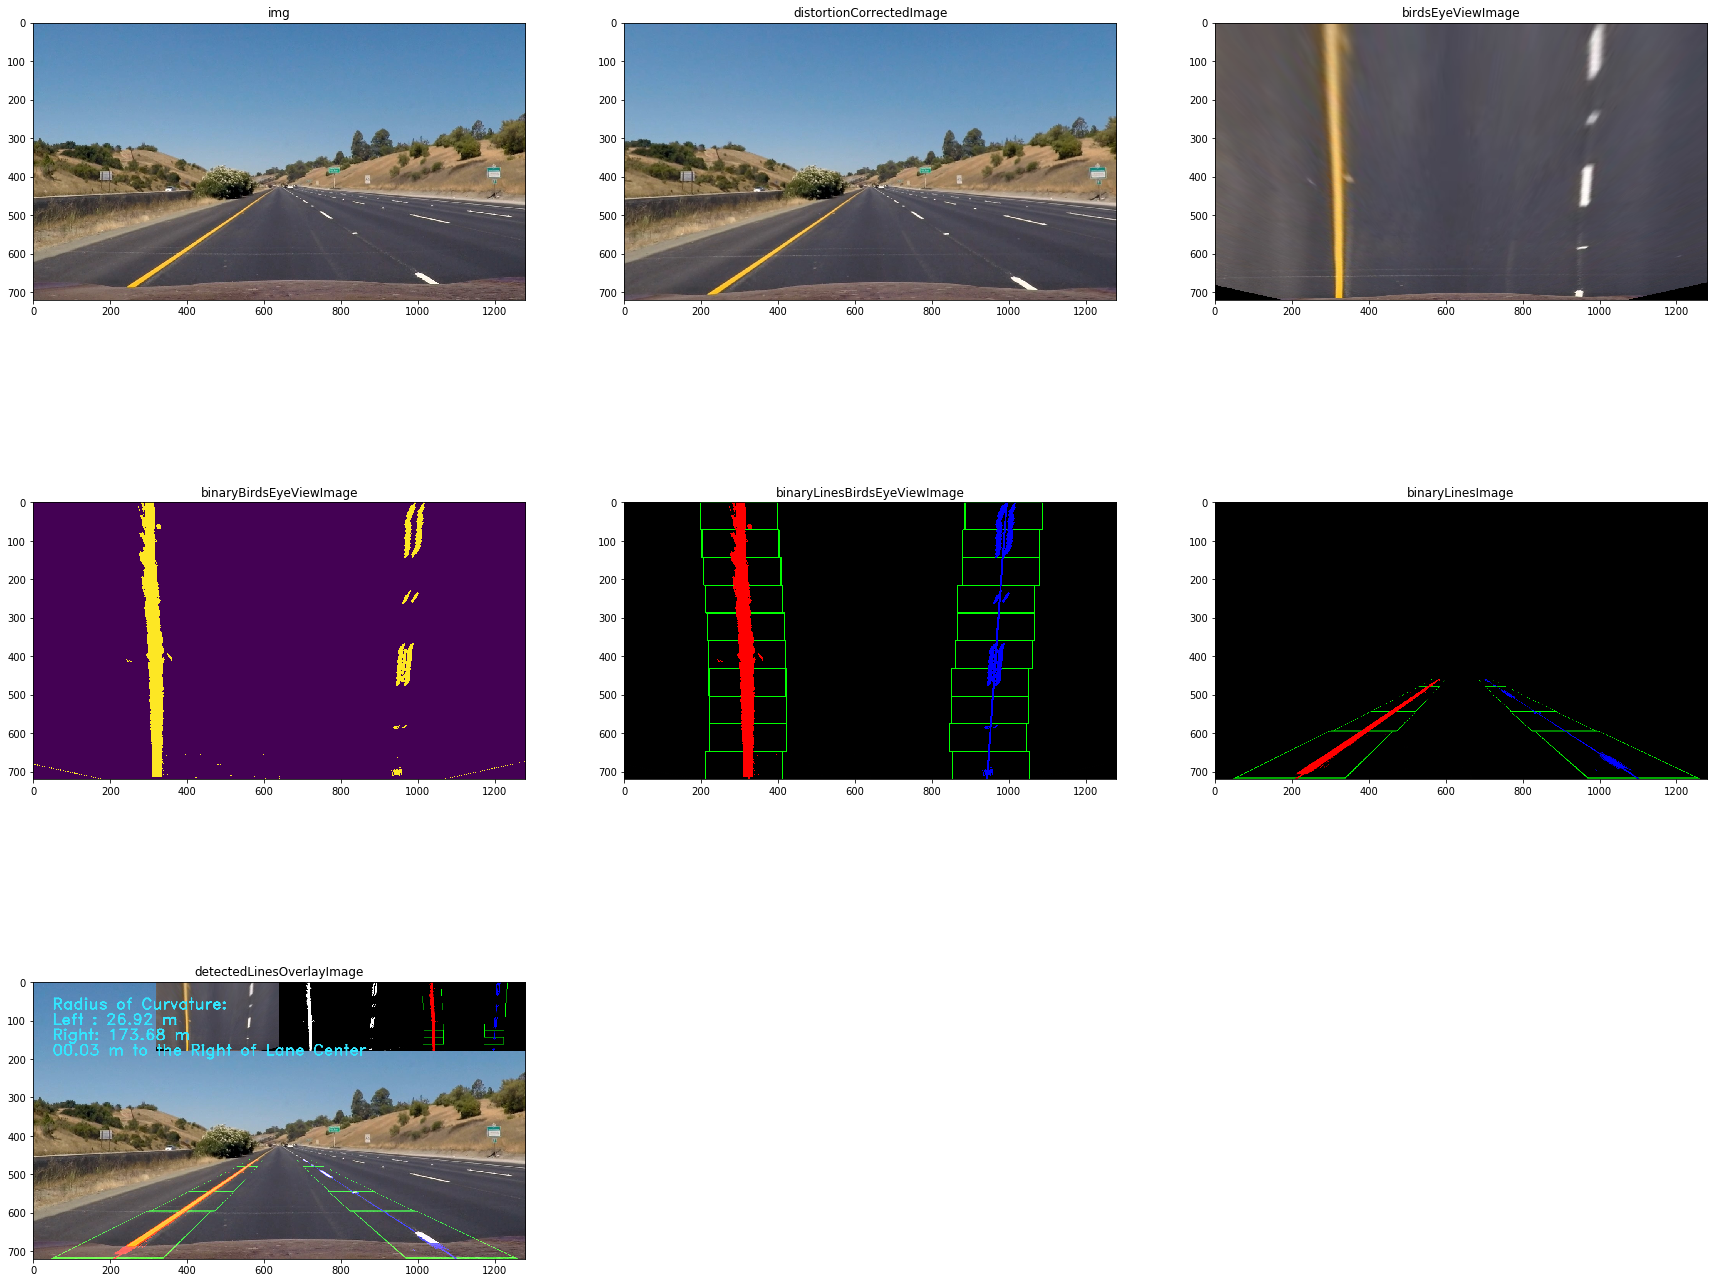

In [20]:
for fileName in glob.glob("test_images/*.jpg"):
    # Clear global each time (none of these images are in sequence)
    leftLine  = Line()
    rightLine = Line()
    print("Running Pipeline On: ", fileName)
    pipeline(mpimg.imread(fileName), True)
    break

## Applying Pipeline To a Video

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import display, HTML

def pipelineVideo(inputPath, outputPath, subclip=False, subclipRange=(0,5)): 
    videoClip = None
    
    # apply subclip if subclip flag is set
    if subclip:
        videoClip = VideoFileClip(inputPath).subclip(subclipRange[0],subclipRange[1])
    else:
        videoClip = VideoFileClip(inputPath)
    
    # close first clip
    videoClip.reader.close()
    videoClip.audio.reader.close_proc()
    
    # apply pipeline to video
    processedClip = videoClip.fl_image(pipeline)

    # write clip to the specified output path
    %time processedClip.write_videofile(outputPath, audio=False)
    
    # close second clip
    processedClip.reader.close()
    processedClip.audio.reader.close_proc()

## Pipelining and Displaying Video

In [22]:
def pipelineAndDisplayVideo(inputPath, outputPath, subclip=False, subclipRange=(0,5)):
    pipelineVideo(inputPath, outputPath, subclip, subclipRange)
    
    display(HTML("""
    <video width="100%" height="100%" controls>
      <source src="{0}">
    </video>
    """.format(outputPath)))

## Running Pipeline on Project Video

In [26]:
leftLine = Line()
rightLine = Line()
pipelineAndDisplayVideo("project_video.mp4", "output_videos/project_video_output.mp4")

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [18:12<00:00,  1.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

Wall time: 18min 32s


## Running Pipeline on Challenge Video

In [24]:
leftLine = Line()
rightLine = Line()
pipelineAndDisplayVideo("challenge_video.mp4", "output_videos/challenge_video_output.mp4", True)

[MoviePy] >>>> Building video output_videos/challenge_video_output.mp4
[MoviePy] Writing video output_videos/challenge_video_output.mp4


100%|██████████| 150/150 [01:11<00:00,  2.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_output.mp4 

Wall time: 1min 20s


## Running Pipeline on Harder Challenge Video

In [25]:
leftLine = Line()
rightLine = Line()
pipelineAndDisplayVideo("harder_challenge_video.mp4", "output_videos/harder_challenge_video_output.mp4", True)

[MoviePy] >>>> Building video output_videos/harder_challenge_video_output.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_output.mp4


 99%|█████████▉| 125/126 [01:08<00:00,  1.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_output.mp4 

Wall time: 1min 17s
